# Race LSTM prediction
The aim of this notebook is to train a LSTM model being able to predict speed of the runner at the next data point.

In [6]:
import glob
import os
import pandas as pd
import random
import dateutil.parser
from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils import np_utils

from sklearn import metrics as me
from sklearn.utils import shuffle
import sklearn.linear_model as lm

%matplotlib inline

In [2]:
# Load the dataset
PATH_DATA = "../data/running/APE_running_data"

def convert(date):
    dt = dateutil.parser.parse(date).replace(tzinfo=None)
    epoch = datetime.utcfromtimestamp(0)
    delta = dt - epoch
    return delta.total_seconds()

colnames = np.array(['time', 'elevation', 'distance', 'speed'])
datasets_all = []

os.chdir(PATH_DATA)
for file in glob.glob("*.tab"):
    print("Processing {}".format(file))
    dataset = np.genfromtxt(file, skip_header=1,delimiter='\t', converters={0: convert})
    dataset[:,0] -= dataset[0,0]
    dataset = pd.DataFrame(dataset,columns=colnames)
    slope = np.array([])
    window_size_half = 8
    for j in dataset.index:
        index = np.arange(j-window_size_half+1, j+window_size_half+1)
        index = index[(index >= 0) & (index < len(dataset))]
        dataset_part = dataset.iloc[index].dropna()
        regr = lm.LinearRegression()
        regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))
        slope = np.append(slope,regr.coef_)
    dataset['slope'] = slope
    if (len(dataset) > 300) == (len(dataset) < 900):
        datasets_all.append(dataset)

print('\nDataset sample')
print(datasets_all[0][:10])
print(len(datasets_all))

Processing activity_437398751.tab
Processing activity_437398728.tab
Processing activity_404227667.tab
Processing activity_437398762.tab
Processing activity_377304158.tab
Processing activity_447149230.tab
Processing activity_437398739.tab
Processing activity_437398771.tab
Processing activity_396872154.tab
Processing activity_447656990.tab
Processing activity_373735080.tab
Processing activity_373734948.tab
Processing activity_437398768.tab
Processing activity_437398746.tab
Processing activity_404227656.tab
Processing activity_437398721.tab
Processing activity_437398717.tab
Processing activity_437398782.tab
Processing activity_373735106.tab
Processing activity_437398753.tab
Processing activity_437398761.tab
Processing activity_377304230.tab
Processing activity_437398778.tab
Processing activity_437398785.tab
Processing activity_379843442.tab
Processing activity_404227695.tab
Processing activity_367230665.tab
Processing activity_447149252.tab
Processing activity_447149261.tab
Processing act

In [18]:
# Number of points taken for each prediction
NB_POINTS = 10
# Number of races taken for the training set
NB_TRAINING =  20
# Number of races taken for the testing set
NB_TEST = 10
# Shuffle data or not ?
SHUFFLE = True
# List of features (columns of dataframe)
FEATURES = ['time', 'distance', 'speed', 'slope']

# Remove NaN values in dataset
dataset = [i.dropna() for i in datasets_all]

# Filter features
dataset = [x[FEATURES] for x in dataset]

# Shuffle the dataset
random.seed(42)
random.shuffle(dataset)

seq = []
next_speed = []

# Creation of train set
for race in range(NB_TRAINING):
    print('Race={} ({} samples) (train)'.format(race, len(dataset[race])))
    seq_local = []
    next_speed_local = []
    for i in range(len(dataset[race])-(NB_POINTS+1)):
        seq_local.append(dataset[race][i:i+NB_POINTS].as_matrix())
        next_speed_local.append(dataset[race][i+NB_POINTS:i+NB_POINTS+1]['speed'].as_matrix())
    seq += seq_local
    next_speed += next_speed_local
        
# Transform the data into numpy arrays 
trainX = np.array(seq)
trainY = np.array(next_speed)
# Shuffle data
if SHUFFLE:
    trainX, trainY = shuffle(trainX, trainY, random_state=42)
        
seq_test = []
next_speed_test = []
# Creation of test set
for race in range(NB_TRAINING, NB_TRAINING + NB_TEST):
    print('Race={} ({} samples) (test)'.format(race, len(dataset[race])))
    seq_test_local = []
    next_speed_test_local = []
    for i in range(len(dataset[race])-(NB_POINTS+1)):
        seq_test_local.append(dataset[race][i:i+NB_POINTS].as_matrix())
        next_speed_test_local.append(dataset[race][i+NB_POINTS:i+NB_POINTS+1]['speed'].as_matrix())
    seq_test += seq_test_local
    next_speed_test += next_speed_test_local
        
# Transform the data into numpy arrays 
testX = np.array(seq_test)
testY = np.array(next_speed_test)
# Shuffle data
if SHUFFLE:
    testX, testY = shuffle(testX, testY, random_state=42)

Race=0 (685 samples) (train)
Race=1 (583 samples) (train)
Race=2 (527 samples) (train)
Race=3 (726 samples) (train)
Race=4 (709 samples) (train)
Race=5 (823 samples) (train)
Race=6 (732 samples) (train)
Race=7 (595 samples) (train)
Race=8 (583 samples) (train)
Race=9 (536 samples) (train)
Race=10 (860 samples) (train)
Race=11 (603 samples) (train)
Race=12 (773 samples) (train)
Race=13 (577 samples) (train)
Race=14 (715 samples) (train)
Race=15 (527 samples) (train)
Race=16 (725 samples) (train)
Race=17 (566 samples) (train)
Race=18 (682 samples) (train)
Race=19 (418 samples) (train)
Race=20 (605 samples) (test)
Race=21 (853 samples) (test)
Race=22 (655 samples) (test)
Race=23 (435 samples) (test)
Race=24 (581 samples) (test)
Race=25 (734 samples) (test)
Race=26 (693 samples) (test)
Race=27 (616 samples) (test)
Race=28 (735 samples) (test)
Race=29 (833 samples) (test)


In [25]:
BATCH_SIZE = 30
NB_EPOCHS = 200
NB_UNITS = 4
# Normalization or not ?
NORM = False

# Create and fit the LSTM network
model = Sequential()

if NORM:
    model.add(BatchNormalization(input_shape=(NB_POINTS, len(FEATURES))))
    model.add(LSTM(NB_UNITS))
else:
    model.add(LSTM(NB_UNITS, input_shape=(NB_POINTS, len(FEATURES))))
    
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(trainX, trainY, epochs=NB_EPOCHS, batch_size=BATCH_SIZE, verbose=1, 
                   validation_data=(testX, testY))

Train on 12725 samples, validate on 6630 samples
Epoch 1/200
12725/12725 [==============================] - 6s - loss: 1.2339 - val_loss: 0.2477
Epoch 2/200
12725/12725 [==============================] - 3s - loss: 0.3517 - val_loss: 0.1744
Epoch 3/200
12725/12725 [==============================] - 2s - loss: 0.3344 - val_loss: 0.1723
Epoch 4/200
12725/12725 [==============================] - 3s - loss: 0.3305 - val_loss: 0.1715
Epoch 5/200
12725/12725 [==============================] - 3s - loss: 0.3291 - val_loss: 0.1711
Epoch 6/200
12725/12725 [==============================] - 3s - loss: 0.3263 - val_loss: 0.1687
Epoch 7/200
12725/12725 [==============================] - 3s - loss: 0.3231 - val_loss: 0.1684
Epoch 8/200
12725/12725 [==============================] - 4s - loss: 0.3239 - val_loss: 0.1715
Epoch 9/200
12725/12725 [==============================] - 4s - loss: 0.3264 - val_loss: 0.1674
Epoch 10/200
12725/12725 [==============================] - 5s - loss: 0.3294 - val_los

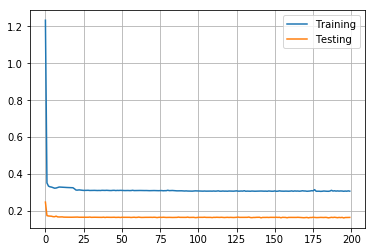

In [27]:
# Plot the training and testing
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

[[ 3.11044407]
 [ 3.11044407]
 [ 3.11044407]
 [ 3.11044407]
 [ 2.89920092]
 [ 2.73723125]
 [ 3.11044407]
 [ 3.11044407]
 [ 3.11044407]
 [ 3.11044407]]
0.0848407


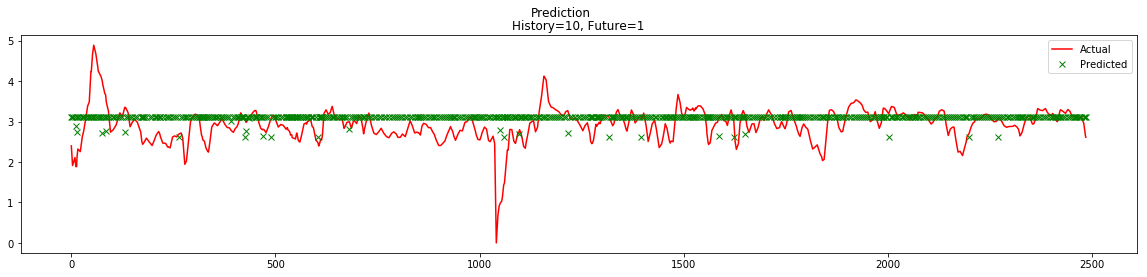

In [28]:
# Plot one race with its prediction
RACE_NUMBER = NB_TRAINING # First race of testing set 
# Actual values
actual = dataset[RACE_NUMBER]
# Predict the future values
# testX contains all the testing races, we need to extract data from the first race
predictY = model.predict(testX[:len(actual)])
print(predictY[:10])
print(np.std(predictY))

# Plot the results
plt.figure(figsize=(20,4))
plt.suptitle('Prediction')
plt.title('History='+str(NB_POINTS)+', Future='+str(1))

# Plot the actual values
plt.plot(actual['time'], actual['speed'], 'r-', label='Actual')
# Plot the predictions
plt.plot(actual['time'], predictY, 'gx', label='Predicted')
plt.legend()

In [8]:
# Information about software version
%load_ext version_information
%reload_ext version_information

%version_information numpy, matplotlib, keras, pandas, sklearn, tensorflow

Software versions
Python 3.6.1 64bit [GCC 6.3.1 20170306]
IPython 6.0.0
OS Linux 4.10.13 1 ARCH x86_64 with arch
numpy 1.12.0
matplotlib 2.0.0
keras 2.0.3
pandas 0.19.2
sklearn 0.18.1
tensorflow 1.1.0
Wed May 24 09:20:29 2017 CEST